## Importing Necessary Libraries and Making Initial Configurations
---

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob

import librosa
import librosa.display
import IPython.display as ipd

from itertools import cycle
import math

## Loading Audio Files
---

### RAVDESS Sampling Function

 - allows for customized querying of the RAVDESS dataset based on desired feature types

In [100]:
# takes path of directory containing all actor subdirectories
# tuples are used to specify the desired types for each feature
#   default is set to include everything
def get_RAVDESS_sample(path, modality: tuple = (1,2,3),
                             voice_channel: tuple = (1,2),
                             emotion: tuple = tuple(range(1,9)),
                             intensity: tuple = (1,2),
                             statement: tuple = (1,2),
                             repitition: tuple = (1,2),
                             actor: tuple = tuple(range(1,25))):
    
    modality = set(modality)
    voice_channel = set(voice_channel)
    emotion = set(emotion)
    intensity = set(intensity)
    statement = set(statement)
    repitition = set(repitition)
    actor = set(actor)
    
    dirs = []
    for d in glob(path+"/Actor_*"):
        if (int(d[-2]+d[-1]) in actor):
            dirs.append(d)
            
    files = []
    for d in dirs:
        d = d+"/"
        for f in glob(d+"*"):
            f = tuple(f.replace(d, ""))
            
            m = int(f[0]+f[1])
            if(m in modality):
                vc = int(f[3]+f[4])
                
                if(vc in voice_channel):
                    e = int(f[6]+f[7])
                    
                    if(e in emotion):            
                        i = int(f[9]+f[10])
                        
                        if(i in intensity):                            
                            s = int(f[12]+f[13])
                            
                            if(s in statement):                                
                                r = int(f[15]+f[16])
                                
                                if(r in repitition):
                                    f = d + "".join(f)
                                    files.append(f)
    
    return files

    

In [103]:
# storing list of all sound file paths
audio_files = get_RAVDESS_sample("./sound_files", (3,), (1,), statement=(1,), repitition=(1,), actor=tuple(range(1,13)))
print(len(audio_files))
audio_files.extend(get_RAVDESS_sample("./sound_files", (3,), (1,), statement=(2,), repitition=(1,), actor=tuple(range(13,25))))
print(len(audio_files))

180
360


In [15]:
# loading audio file using librosa
digital_signal, sample_rate = librosa.load(audio_files[15], sr=None, mono=True)
print(f"number of samples: {len(digital_signal)}")
print(f"original sample rate: {sample_rate}/s")
print(f"audio duration: {len(digital_signal)/sample_rate}")

number of samples: 190591
original sample rate: 48000/s
audio duration: 3.970645833333333


## Analyzing and Preparing Audio Files
---

In [16]:
def plot_signal(signal, sample_rate, plot_title = "Audio Signal"):
    df = pd.DataFrame({
        'signals' : signal,
        'seconds' : [i/sample_rate for i in range(0, len(signal))]
    })
    df.plot(y="signals", x="seconds", figsize=(15,5), lw=0.1, title=plot_title, xlabel="seconds", ylabel="amplitude")

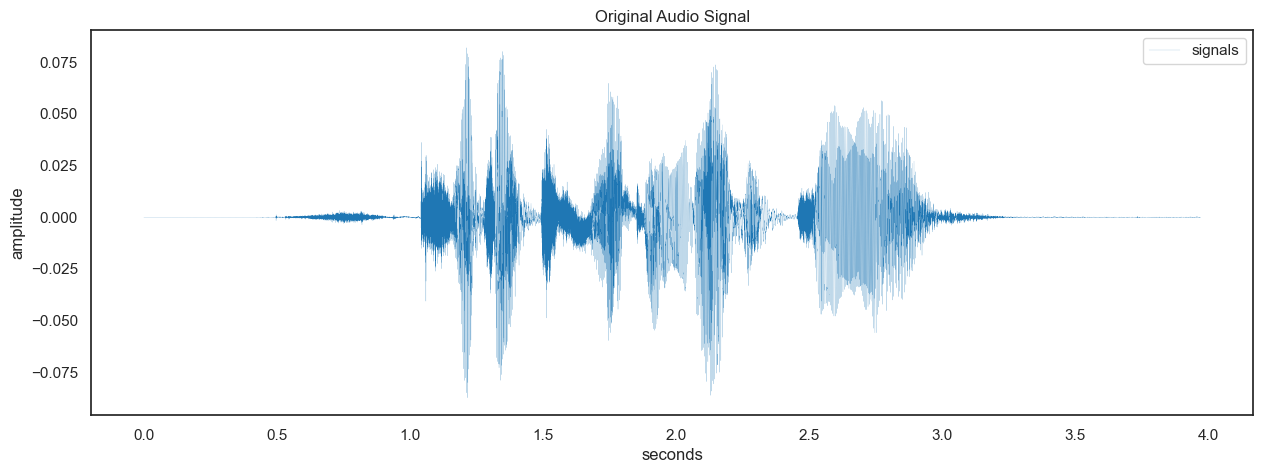

In [17]:
# plotting digital signal
plot_signal(digital_signal, sample_rate, "Original Audio Signal")
ipd.Audio(digital_signal, rate=sample_rate)

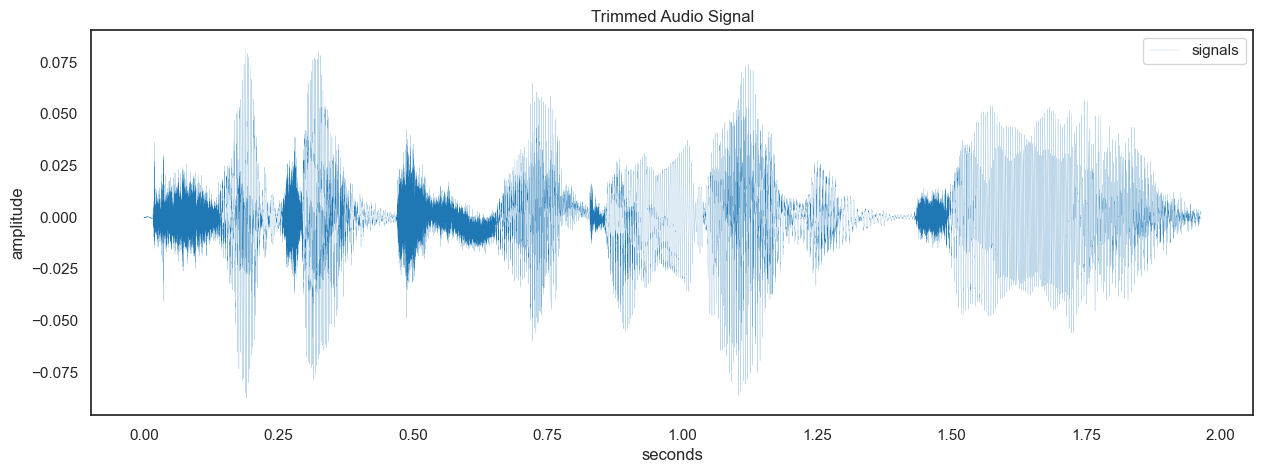

In [18]:
# trimmed signal
db = 20 * (math.log10(max(digital_signal)) - math.log10(0.005))
trimed_signal, _ = librosa.effects.trim(digital_signal, top_db=db)
plot_signal(trimed_signal, sample_rate, "Trimmed Audio Signal")
ipd.Audio(trimed_signal, rate=sample_rate)

## Adding Noise
---

In [19]:
# noise generation functions

def generate_white_noise_gaussian(length, std_dev=0.1):
    return np.random.normal(0, std_dev, length)

def generate_white_noise_uniform(length):
    return np.random.uniform(-1,1,length)


# mixing function

def add_noise(noise_type, signal, snr=1):
    
    signal_len = len(signal)
    signal_power = np.sum(signal**2)/signal_len
    signal_std_dev = np.std(signal)
    
    if noise_type == 'n':
        noise = generate_white_noise_gaussian(signal_len, signal_std_dev)
    else:
        noise = generate_white_noise_uniform(signal_len)
    
    noise_power = np.sum(noise**2)/signal_len
    scale_factor = math.sqrt( (signal_power/noise_power)*(10**(-snr/10)) )
    
    noise *= scale_factor
    noisy_audio = noise + signal
    
    return noisy_audio
    

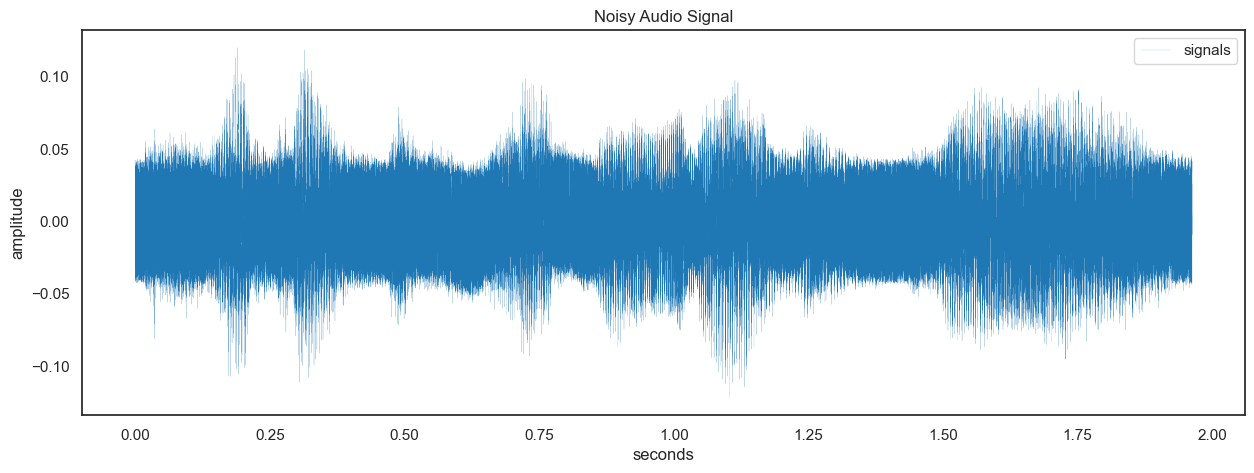

In [20]:
# requesting desired signal to noise ratio
snr = input("Please enter the required signal to noise ratio")
snr = int(snr)

# generating noisy audio
choice = input("Enter 'n' for gaussian white noise or 'u' for uniform white noise")

noisy_audio = add_noise(choice, trimed_signal, snr=snr)    
plot_signal(noisy_audio, sample_rate, "Noisy Audio Signal")
ipd.Audio(noisy_audio, rate=sample_rate)